# Support Vector Machines

revision: 78571a2

In [2]:
# @formatter:off
# PREAMBLE
import cvxopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
# @formatter:on

In [3]:
# Open kernels.py and implement the function sq_exp (can be copied from previous problem set)
from mlis.kernels.kernels import sq_exp

sigma = 10
X = np.array([[1, 2, -1], [3, 2, 1]])
Z = np.array([[5, 1, 5]])
# test shape
np.testing.assert_array_equal(sq_exp(X, Z, sigma).shape, (2, 1))
np.testing.assert_array_almost_equal(sq_exp(X, Z, sigma), [[0.767], [0.9]], decimal=3)

### SVM Dual Form

Recall the primal support vector machine optimization problem:
$$
\begin{align}
\min_{w,b}\quad & \lVert w \rVert^2 + C \sum_{i=1}^n \xi_i \\
\text{s.t.}\quad & y_i(w^Tx_i + b) \geq 1 - \xi_i\\
& \xi_i \geq 0
\end{align}
$$

We can form the Lagrangian:
$$
\mathcal{L}(w,b,\xi,\alpha,\gamma) = \frac{1}{2}w^Tw + C\sum_{i=1}^n \xi_i - \sum_{i=1}^n\alpha_i[y_i(x_i w+b) -w +\xi_i] - \sum_{i=1}^n\gamma_i\xi_i
$$

Here, the $\alpha_i$'s and $\gamma_i$'s are our Lagrange multipliers (constrained to be $\geq 0$).

After setting the derivatives with respect to w and b to zero as before, substituting them back in, and simplifying, we obtain the following dual form of the problem:

$$
\begin{align}
\max_{\alpha} \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n y_iy_j\alpha_i\alpha_j \langle x_i, x_j \rangle \\
\text{s.t.}\quad & 0\leq \alpha_i\leq C\\
& \sum_{i=1}^n \alpha_i y_i = 0
\end{align}
$$

We have that $w$ can be expressed in terms of the $\alpha_i$'s given by
$$
w = \sum_{i=1}^n \alpha_i y_i x_i,
$$
so that after solving the dual problem, we can use
$$
f(x) = w^Tx+b = \sum_{i=1}^n \alpha_i y_i \langle x_i, x \rangle +b
$$
to make our predictions.

Since the algorithm can be written entirely in terms of the inner products $\langle x, z \rangle$, this means that we would replace all those inner products with $\langle \phi(x), \phi(z) \rangle$. Specificically, given a feature mapping $\phi$, we define the corresponding kernel to be
$$
k(x, z) = \langle \phi(x), \phi(z) \rangle.
$$
Then, everywhere we previously had $\langle x, z \rangle$ in our algorithm, we could simply replace it with $k(x, z)$, and our algorithm would now be learning using the features $\phi$.

### Solving the svm dual optimization problem with Quadratic Programming

The SVM dual problem can be optimized by quadratic programming. You need to download and install a third party library called "cvxopt".

Quadratic programming is a general optimization routine to find a minimum for a problem specified by
$$
\begin{align}
\min_x\quad& \frac{1}{2} x^TPx + q^Tx\\
\text{s.t.}\quad & Gx \leq h\\
& Ax = b
\end{align}
$$
and we have to bring the SVM dual into this form.

In [12]:
# wrapper around cvxopt
def quadprog(P, q, G, h, A, b):
    sol = cvxopt.solvers.qp(cvxopt.matrix(P),
                            cvxopt.matrix(q),
                            cvxopt.matrix(G),
                            cvxopt.matrix(h),
                            cvxopt.matrix(A),
                            cvxopt.matrix(b))
    return np.ravel(sol['x'])

#### The Quadratic Program
We write the SVM optimization problem as a Quadratic Program.
Let $K$ be the $m \times m$ Gram matrix with $K_{i,j} = k(x_i,x_j)$ then

$$
\begin{align}
P & = \vec{y}\vec{y}^T \circ K \in \mathbb{R}^{m \times m}\\
q & = -\vec{1} \in \mathbb{R}^{m}\\
G & = \begin{bmatrix} -I \\ I \end{bmatrix} \in \mathbb{R}^{2m \times m} \\
h & = \begin{bmatrix}\vec{0}\\\vec{1}\cdot C\end{bmatrix} \in \mathbb{R}^{2m}\\
A & = \vec{y}^T \in \mathbb{R}^{1 \times m}\\
b & = 0.0 \in \mathbb{R}
\end{align}
$$

where $I$ is the identity matrix of size $m\times m$.

Implement the function `lagrange_multipliers` to calculate these quantities and call `quadprog` to obtain the $\alpha$'s.

In [35]:
from mlis.kernels.kernel_svm import lagrange_multipliers

C = 1
y = np.array([[-1.], [1], [1.]])
K = np.array([
    [1., .1, .1],
    [.1, 1., .99],
    [.1, .99, 1],
])
alpha = lagrange_multipliers(y, C, K)
np.testing.assert_array_almost_equal(alpha, [1., 0.5, 0.5], decimal=3)

     pcost       dcost       gap    pres   dres
 0: -1.0438e+00 -4.7956e+00  4e+00  6e-17  4e-16
 1: -1.0684e+00 -1.2101e+00  1e-01  2e-16  2e-16
 2: -1.0987e+00 -1.1053e+00  7e-03  2e-16  7e-17
 3: -1.1024e+00 -1.1025e+00  1e-04  1e-16  6e-17
 4: -1.1025e+00 -1.1025e+00  1e-06  2e-16  8e-17
 5: -1.1025e+00 -1.1025e+00  1e-08  9e-17  4e-17
Optimal solution found.


The optimal bias $b$ can be determined by KKT dual-complementarity conditions which quarantees that
$$
y_i (w^Tx_i + b) = 1 \quad\text{if}\quad 0 < \alpha_i < C
$$
and hence
$$
\begin{align}
y_i (w^Tx_i + b) &= 1\\
w^Tx_i + b &= y_i\\
b &= y_i - w^Tx_i\\
&= y_i - \sum_{j=1}^n \alpha_j y_j k(x_j, x_i)
\end{align}
$$
for any $0 < \alpha_i < C$.

Implement the function `bias` to obtain $b$.

In [33]:
from mlis.kernels.kernel_svm import bias

C = 1
y = np.array([[-1.], [1], [1.]])
K = np.array([
    [1., .1, .1],
    [.1, 1., .99],
    [.1, .99, 1],
])
alpha = np.array([1., 0.5, 0.5])
b = bias(y, C, alpha, K)

np.testing.assert_array_almost_equal(b, 0.005, decimal=3)

We now have function to calculate $\alpha$ and $b$. This allows us to implement the support vector machine. 
The function `svm_fit` first computes $\alpha$ and $b$ and then returns a function
$$
z\mapsto \sum_{i=1}^n \alpha_i y_i k(x_i, z) +b
$$
which is able to make predictions for new data point $z$.

     pcost       dcost       gap    pres   dres
 0: -8.6459e-01 -4.5947e+02  2e+03  1e+00  6e-16
 1:  1.9031e+00 -1.4131e+02  2e+02  3e-02  6e-16
 2: -7.9243e-01 -9.3229e+00  9e+00  9e-04  7e-16
 3: -1.9727e+00 -3.5910e+00  2e+00  1e-04  5e-16
 4: -2.1932e+00 -2.9799e+00  8e-01  2e-05  3e-16
 5: -2.3013e+00 -2.6866e+00  4e-01  4e-06  2e-16
 6: -2.3485e+00 -2.5441e+00  2e-01  8e-07  2e-16
 7: -2.3794e+00 -2.4425e+00  6e-02  2e-07  2e-16
 8: -2.3851e+00 -2.4322e+00  5e-02  1e-07  2e-16
 9: -2.3983e+00 -2.4047e+00  6e-03  9e-09  3e-16
10: -2.3997e+00 -2.4027e+00  3e-03  3e-09  2e-16
11: -2.4000e+00 -2.4023e+00  2e-03  2e-09  2e-16
12: -2.4010e+00 -2.4012e+00  2e-04  3e-11  3e-16
13: -2.4011e+00 -2.4011e+00  2e-06  4e-13  3e-16
14: -2.4011e+00 -2.4011e+00  2e-08  4e-15  3e-16
Optimal solution found.


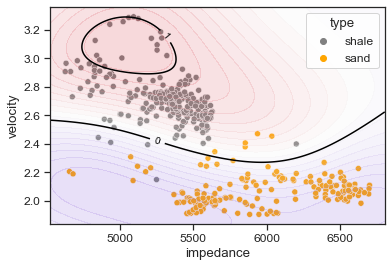

In [34]:
from mlis.kernels.kernel_svm import svm_fit


# Plotting decision regions
def plot_fit(h=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(ax=ax, x='impedance', y='velocity', hue='type', data=df, palette=dict(sand='orange', shale='gray'))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    scaler = preprocessing.StandardScaler().fit(df[['impedance', 'velocity']].values)
    if h:
        grid = 150
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], grid), np.linspace(ylim[0], ylim[1], grid))
        XY = np.array([np.ravel(xx), np.ravel(yy)]).T
        XY = scaler.transform(XY)
        P = h(XY).reshape(grid, grid)
        cmap = sns.diverging_palette(275, 10, as_cmap=True)
        ax.contourf(xx, yy, P, alpha=.2, cmap=cmap, levels=np.linspace(P.min(), P.max(), 20))
        # cn = ax.contour(xx, yy, P, colors='k', levels=10)
        cn = ax.contour(xx, yy, P, colors='k', levels=[-1,0,1])
        ax.clabel(cn, inline=1, fontsize=10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


# load rock types data set
df = pd.read_csv('rocktypes.csv', sep=' ')
X = df[['impedance', 'velocity']].values
y = df['type'].apply(lambda string: -1 if string == 'sand' else +1).values
# normalize data using scipy
X = preprocessing.StandardScaler().fit_transform(X)

# learn the support vector machine
sigma = 1.0
C = 1
kernel = lambda X, Z: sq_exp(X, Z, sigma)
svm = svm_fit(X, y, C, kernel)

plot_fit(svm)